In [1]:
%matplotlib inline


# Getting started tutorial

In this introductory example, you will see how to use the :code:`spikeinterface` to perform a full electrophysiology analysis.
We will first create some simulated data, and we will then perform some pre-processing, run a couple of spike sorting
algorithms, inspect and validate the results, export to Phy, and compare spike sorters.


# TODO: 
- Try to label each unit id with the same color across plots

In [2]:
import os
from collections import defaultdict
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import glob
from pathlib import Path


In [3]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [4]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [5]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/nancy/user/riwata/projects/spike_gadgets_repo/bin/conda_environment/spike_interface_env/lib/python3.9/site-packages/spikeextractors/extractors/mearecextractors/mearecextractors.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if StrictVersion(mr.__version__) >= '1.5.0':
/tmp/ipykernel_1081508/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [6]:
import spikeinterface.core

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [7]:
import spikeinterface.full as si

In [8]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 0: Imorting Processes Recording and Spike Sorting Data from Previous Notebook

## Loading in the Preprocessed Electrophysiology Recording

- We are inputting the electrophsiology recording data with probe information. This should have been created in the prevous notebook in a directory created by Spike Interface. If you had already read in your own electrophsiology recording data with probe information with a different way, then follow these instructions.
    - If you want to use a different directory, then you must either:
        - Change `glob.glob({./path/to/with/*/preprocessing})` to the directory that you have the directories created from Spikeinterface. You can use a wildcard if you have multiple folders. You would replace `{./path/to/with/*/preprocessing}` with the path to either the parent directory or the actual directory containing the electrophsiology recording data read into Spikeinterface.
        - Or change `(file_or_folder_or_dict={./path/to/preprocessing})`. You would replace `{./path/to/preprocessing}` with the path to either the parent directory or the actual directory containing the electrophsiology recording data read into Spikeinterface.

In [9]:
all_recording_preprocessing_directories = glob.glob("./proc/*/preprocessing", recursive=True)

In [10]:
all_recording_preprocessing_directories = sorted(all_recording_preprocessing_directories)

In [11]:
all_recording_preprocessing_directories

['./proc/20220907_140232test/preprocessing']

- If you have more than one recording directory, then you must either:
    - A. Put the index of the file in `all_recording_directories[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `(file_or_folder_or_dict={./path/to/recording_file.rec}`) below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [12]:
# To be used for all steps
recording_preprocessed = spikeinterface.core.load_extractor(file_or_folder_or_dict=all_recording_preprocessing_directories[0])

In [13]:
type(recording_preprocessed)

spikeinterface.core.binaryfolder.BinaryFolderRecording

## Metadata from the recording file

- This is how you retrieve info from a :code:`RecordingExtractor`...


In [14]:
channel_ids = recording_preprocessed.get_channel_ids()
fs = recording_preprocessed.get_sampling_frequency()
num_chan = recording_preprocessed.get_num_channels()
num_seg = recording_preprocessed.get_num_segments()
duration = recording_preprocessed.get_num_frames()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print('Duration:', duration)
print('Number of hours:', duration/fs/3600)

Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 20000.0
Number of channels: 32
Number of segments: 1
Duration: 6768567
Number of hours: 0.094007875


- Looking over the recording file

Text(0, 0.5, 'Channels')

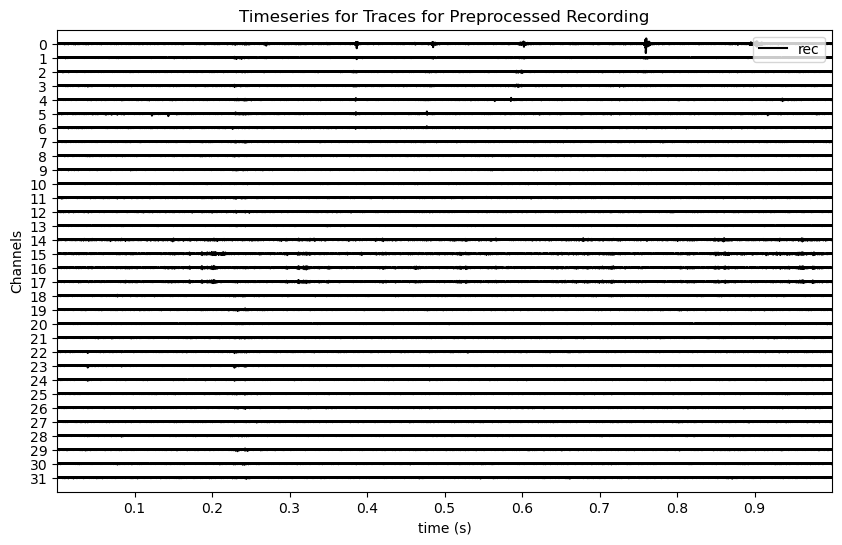

In [15]:
sw.plot_timeseries(recording_preprocessed, show_channel_ids=True)
plt.title("Timeseries for Traces for Preprocessed Recording")
plt.ylabel("Channels")

In [16]:
channel_ids = np.random.choice(recording_preprocessed.channel_ids, size=5, replace=False)

In [17]:
channel_ids = sorted(channel_ids, key=lambda x: float(x))

Text(0, 0.5, 'Channels')

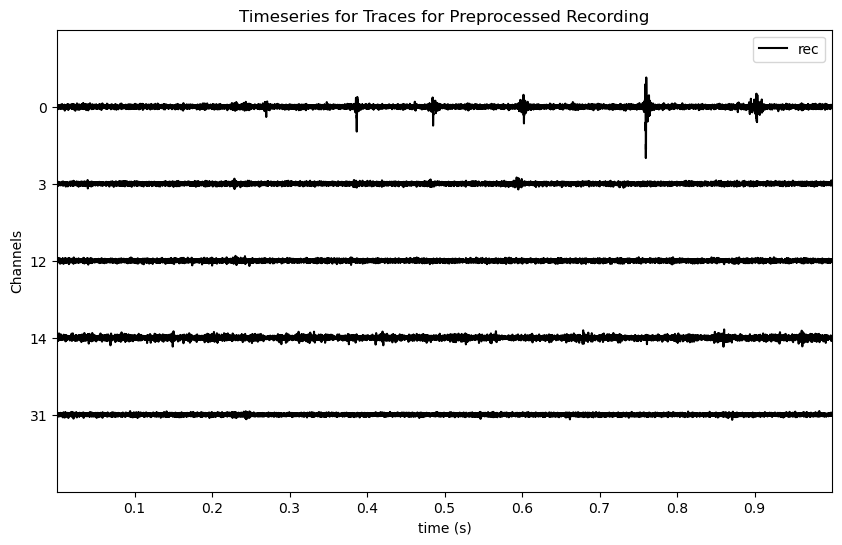

In [18]:

sw.plot_timeseries(recording_preprocessed, channel_ids=channel_ids, show_channel_ids=True)
plt.title("Timeseries for Traces for Preprocessed Recording")
plt.ylabel("Channels")

- Importing the Spike Sorting Output

In [19]:
all_spikesorting_directories = glob.glob("./proc/**/ss_output", recursive=True)

In [20]:
all_spikesorting_directories = sorted(all_spikesorting_directories)

In [21]:
all_spikesorting_directories

['./proc/20220907_140232test/mountainsort4/2022_09_26/ss_output']

- If you have more than one recording directory, then you must either:
    - A. Put the index of the file in `all_spikesorting_directories[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `ss.read_sorter_folder({./path/to/spikesorting_directory}`) below. You would replace `{./path/to/spikesorting_directory}` with the path of the file for the spike sorting output directory.

In [22]:
spike_sorted_object = ss.read_sorter_folder(all_spikesorting_directories[0])

In [23]:
type(spike_sorted_object)

spikeinterface.core.npzsortingextractor.NpzSortingExtractor

- TODO's
    - Look into what the parameters do(like freq_min)
    - Compare it with the original recording 
    - Plotting PC space and ISI(interspike interval interval)
    - Average wave form of each 
    - Look over Maya's video and follow her visualization

# Part 1: Post Processing

- Different resources to look at for Post Processing
    - https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_2_postprocessing.html
    - https://github.com/SpikeInterface/spiketutorials/blob/master/Official_Tutorial_SI_0.90_Aug2021/SpikeInterface_Tutorial.ipynb
    - https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_3_quality_mertics.html
    - https://catalystneuro.github.io/spike-sorting-hackathon/

## Creating a folder for Spike Sorting Output

In [24]:
child_spikesorting_output_directory = Path(all_spikesorting_directories[0])
parent_spikesorting_output_directory = child_spikesorting_output_directory.parent.absolute()

In [25]:
parent_spikesorting_output_directory

PosixPath('/nancy/user/riwata/projects/spike_gadgets_repo/results/2022_09_22_phy_trouble_shooting/10_spike_interface_git_issue/proc/20220907_140232test/mountainsort4/2022_09_26')

- Creating a directory within the spike sorting directory for saving extracted waveforms 

In [26]:
waveform_output_directory = os.path.join(parent_spikesorting_output_directory, "waveforms")

In [27]:
waveform_output_directory

'/nancy/user/riwata/projects/spike_gadgets_repo/results/2022_09_22_phy_trouble_shooting/10_spike_interface_git_issue/proc/20220907_140232test/mountainsort4/2022_09_26/waveforms'

## Extracting Waveforms

In [28]:
from spikeinterface import WaveformExtractor, extract_waveforms
import spikeinterface.extractors as se

- The WaveformExtractor class:
    - randomly samples a subset spikes with max_spikes_per_unit
    - extracts all waveforms snippets for each unit
    - saves waveforms in a local folder
    - can load stored waveforms
    - retrieves template (average or median waveform) for each unit
    - https://spikeinterface.readthedocs.io/en/latest/modules/core/plot_4_waveform_extractor.html



- Extracting waveforms from preprocessed recordings and spike sorted output from spike_sorted 
    - Based on Maya's settings in recorded video 
    - Saving to folder

In [29]:
we_spike_sorted = si.extract_waveforms(recording=recording_preprocessed, 
                                       sorting=spike_sorted_object, folder=waveform_output_directory,
                                      ms_before=1, ms_after=1, progress_bar=True,
                                      n_jobs=8, total_memory="1G", overwrite=True,
                                       max_spikes_per_unit=2000)

extract waveforms memmap:   0%|          | 0/4 [00:00<?, ?it/s]

- Loading from folder

In [30]:
we_spike_sorted = WaveformExtractor.load_from_folder(waveform_output_directory)

- Make into code cell if you want to look at details of waveform extraction

# Exporting for Manual Curation

Once we have the  `WaveformExtractor` object
we can post-process, validate, and curate the results. With
the :code:`toolkit.postprocessing` submodule, one can, for example,
get waveforms, templates, maximum channels, PCA scores, or export the data
to Phy. `Phy <https://github.com/cortex-lab/phy>`_ is a GUI for manual
curation of the spike sorting output. To export to phy you can run:



In [31]:
from spikeinterface.exporters import export_to_phy



In [32]:
phy_output_directory = os.path.join(parent_spikesorting_output_directory, "phy")

In [33]:
phy_output_directory

'/nancy/user/riwata/projects/spike_gadgets_repo/results/2022_09_22_phy_trouble_shooting/10_spike_interface_git_issue/proc/20220907_140232test/mountainsort4/2022_09_26/phy'

In [34]:
export_to_phy(we_spike_sorted, phy_output_directory,
              compute_pc_features=True, compute_amplitudes=True, remove_if_exists=True)

write_binary_recording with n_jobs = 1 and chunk_size = None
Run:
phy template-gui  /nancy/user/riwata/projects/spike_gadgets_repo/results/2022_09_22_phy_trouble_shooting/10_spike_interface_git_issue/proc/20220907_140232test/mountainsort4/2022_09_26/phy/params.py
